# Miguel López Vélez cc 1001014378
# Andres Ruiz cc 1007448685

Proyecto 1 Bioseñales y sistemas

Objetivos:

-Aprender a usar Python para la manipulación y visualización básica de señales

-Programar operaciones matemáticas sobres señales

-Hacer comparaciones e inferencias sobre conjuntos de datos


<h4>Se importan las librerías necesarias<h4>

In [1]:
#libreria para manejo de NDARRAY
import numpy as np;
import scipy as sp
#libreria para graficar
import matplotlib.pyplot as plt
#Lector de archivos csv
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg

<h2>Carga de archivos .mat<h2>

In [131]:
ruta_carpeta = './control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(data)

ruta_carpeta = './parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(data)
print("Todo cargado")

Todo cargado


<h2>Punto 1<h2>

<h5>Se calcula la densidad espectral de potencia para una señal de EEG utilizando funciones de numpy<h5>

In [132]:
def ecu_spectraldensity(xn,nl,N):
    sums_sk=[]
    w_n=0.42-0.5*np.cos((2*np.pi*nl)/(N-1)) #Se define w_n
    xn=w_n*xn #Se multiplica w_n por la señal
    for k in nl: #Se realiza un for para recorrer los diferentes k de la sumatoria
        s_k=np.abs(np.sum(xn*np.exp((-1j*2*np.pi*k*nl)/N)))**2 #Por último se aplica la fórmula planteada
        sums_sk.append(s_k)
    return np.array(sums_sk)/N

In [133]:
def spectraldensity(xn,epoca=119,paciente=0): 
    """Esta función recibe la matriz con los diferentes archivos, toma un paciente y de este una época
    con esto calcula la densidad espectral de potencia de cada canal"""
    xn=xn[paciente]
    xn=xn[:,:,epoca]
    sums_k_list=[]
    for canal in xn:
        N=len(canal)
        nl=np.arange(N)
        s_k=ecu_spectraldensity(canal,nl,N)
        sums_k_list.append(s_k)
    return sums_k_list

Ejemplo de lo realizado con el paciente 0 y la época 119, se grafica cada canal


In [134]:
x=spectraldensity(datos_matriz,119,0)


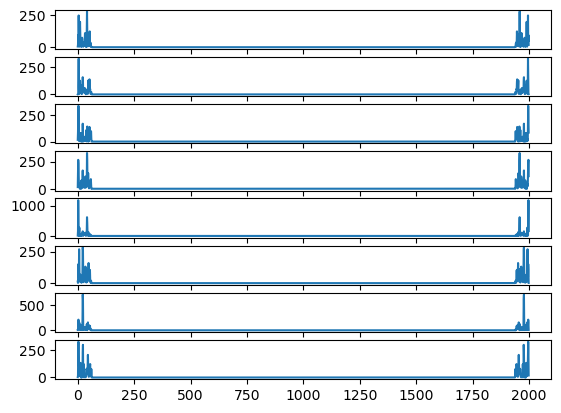

In [135]:
for i in range(len(x)):
    plt.subplot(8,1,i+1)
    plt.plot(x[i])
plt.show()

# Punto 2 
Crear una función que reciba una señal EEG de múltiples épocas, un canal, y devuelva la sumatoria de densidad espectral de potencia, para el rango de frecuencia de 13 a 30 Hz, del promedio de la densidad espectral de potencia de las diferentes épocas de la señal de análisis

In [136]:
def sum_spectraldensity(data,canal=0,paciente=0,fs=1000,fini=13,ffin=30):
    """Esta funcion toma un paciente de la matriz de datos y calcula la sumatoria para sk"""
    data=data[paciente][canal,:,:]
    puntos=[]
    for punto in data:
        p=np.mean(punto)
        puntos.append(p)
    z=np.array(puntos)
    N=len(z)
    nl=np.arange(N)
    s_k=ecu_spectraldensity(z,nl,N)
    frecuencia=np.linspace(0,fs,num=N)
    return s_k,frecuencia

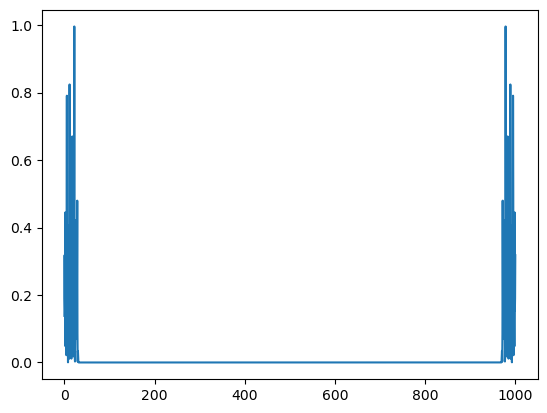

In [137]:
x,f=sum_spectraldensity(datos_matriz,0,0)
plt.plot(f,x)

Se acota según el rango deseado (13Hz a 30Hz)

In [138]:
def spectralrange(x,f,ini=13,end=30):
    bf=np.where((f>=13) &(f<=30))
    f=f[bf]
    x=x[bf]
    return f,x

Se grafica un ejemplo

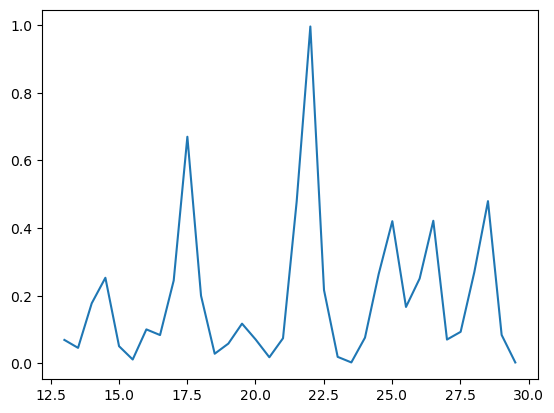

In [139]:
f,x=spectralrange(x,f,13,30)
plt.plot(f,x)

# Punto 3
Crear una función  que  reciba una señal EEG de múltiples canales y múltiples épocas y devuelva los valores calculados en el punto para cada  canal por separado

In [235]:
def PSD(data,paciente=0):
    sums_k_list=[]
    canales=np.arange(len(data[paciente][:,0,0]))

    for canal in canales:
        s_k,f=sum_spectraldensity(data,canal,paciente)
        f,x=spectralrange(s_k,f)
        
        s_k=np.sum(x)
        sums_k_list.append(s_k)
    return sums_k_list

In [236]:
X=PSD(datos_matriz)

In [142]:
print(X)

[6.588136262156796, 7.170274084597011, 8.488089358209756, 6.342503451805725, 6.311502654693775, 8.79407395065854, 7.26157308045821, 11.369824100507422]


# Punto 4
Rutina que aplique sobre todos los archivos de la base de datos la rutina 3 y almacene los resultados en un dataframe donde se pueda discriminar sujeto, control o paciente y el promedio de densidad espectral de potenciapara cada canal

In [143]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos anidados para recorrer la matriz de pacientes y los canales de cada uno de estos"""

for i in r:
    promcanales=["Control"]
    x=PSD(datos_matriz,i)
    for canal in x:
        promcanales.append(canal)
    datosprompaciente.append(promcanales)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales=["Parkinson"]
    x=PSD(datos_parkinson,i)
    for canal in x:
        promcanales.append(canal)
    datosprompaciente_p.append(promcanales)

In [108]:
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2'] #Los nombres de las columnas

In [169]:

df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
Sujeto,,,,,,,,,
1,Control,6.588136,7.170274,8.488089,6.342503,6.311503,8.794074,7.261573,11.369824
2,Control,6.937180,4.682711,2.739435,2.267806,4.730358,13.290693,11.449452,12.883728
3,Control,4.018534,3.599051,5.457592,2.222556,5.556907,2.553184,2.944823,4.609807
4,Control,9.762080,6.623699,9.884979,11.724950,14.610523,22.633438,15.156428,12.204539
5,Control,5.309109,6.728339,8.453612,8.823974,8.370769,10.319439,9.530214,9.589701
6,Control,6.184479,5.465086,4.825497,3.054241,3.661056,4.980654,5.412684,6.552773
7,Control,4.139802,2.935076,3.841803,4.263166,5.032301,7.541838,6.499612,9.207845
8,Control,3.629768,2.767345,2.806591,2.857862,5.790350,6.864858,6.927915,9.292365
9,Control,1.926986,2.042166,2.071883,1.542974,1.392093,12.023476,8.962724,8.070981


Se crean archivos cvs para evitar estar cargando las fórmulas y los datos cada vez que se requiera trabajar con las señales

In [170]:
df.to_csv("Tabla.cvs",index=False)

In [17]:
df=pd.read_csv("Tabla.cvs")

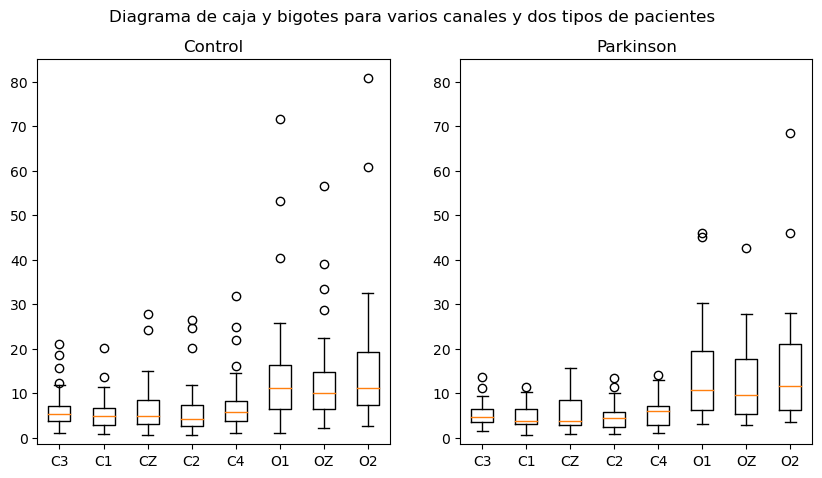

In [18]:
# Crear una lista de dataframes, uno por cada estado
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']
labels1=['C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2']
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
    axs[i].set_ylim([-1.5, 85])
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

Filtro de datos atípicos, se reemplazaron por el promedio de los datos del mismo canal y del mismo estado de paciente (control o parkinson)

In [54]:
def filtro(tabla,ncolumna=int,rango=int,mayorque=True):
    if mayorque:
        columna=tabla.columns[ncolumna]
        locateado=(tabla[columna]>rango).values
        tabla.loc[locateado,columna]=None
        prom=tabla.dropna()
        prom1=prom[columna].mean()
        tabla=tabla.fillna(prom1)
        print("Canal "+columna+" filtrado")
        return tabla
    else:
        columna=tabla.columns[ncolumna]
        locateado=(tabla[columna]<rango).values
        tabla.loc[locateado,columna]=None
        prom=tabla.dropna()
        prom1=prom[columna].mean()
        tabla=tabla.fillna(prom1)
        print("Canal "+columna+" filtrado")
        return tabla

In [20]:
control, parkinson = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]
#filtrado para control
print("Filtro control:")
control=filtro(control,8,30)
control=filtro(control,7,25)
control=filtro(control,6,30)
control=filtro(control,5,20)
control=filtro(control,3,20)
control=filtro(control,4,20)
control=filtro(control,1,20)
#Filtrado para parkinson
print("Filtro Parkinson:")
parkinson=filtro(parkinson,8,40)
parkinson=filtro(parkinson,6,26)
parkinson=filtro(parkinson,7,30)

Filtro control:
Canal PSD_O2 filtrado
Canal PSD_OZ filtrado
Canal PSD_O1 filtrado
Canal PSD_C4 filtrado
Canal PSD_CZ filtrado
Canal PSD_C2 filtrado
Canal PSD_C3 filtrado
Filtro Parkinson:
Canal PSD_O2 filtrado
Canal PSD_O1 filtrado
Canal PSD_OZ filtrado


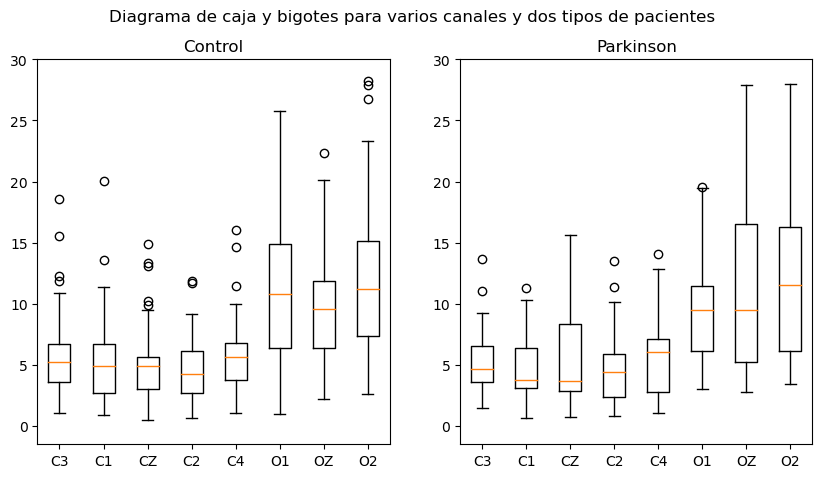

In [21]:
dataframes = control,parkinson
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
    axs[i].set_ylim([-1.5, 30])
    
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

In [30]:
df=pd.concat(dataframes,ignore_index=True)
df.to_csv("Datos_filtrados.cvs",index=False)

In [2]:
df=pd.read_csv("Datos_filtrados.cvs")

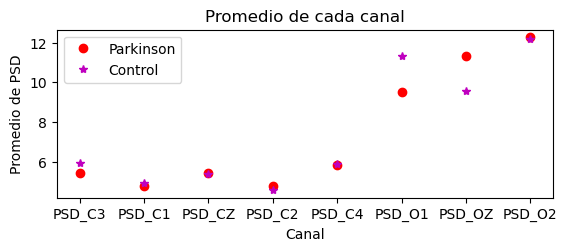

In [93]:
control,parkinson = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]
prom=[]
for i in control.columns[1:]:
    prom.append(control[i].mean())
promcontrol=pd.DataFrame(columns=control.columns[1:].to_list())
promcontrol.loc[0]=prom
prom=[]
for i in parkinson.columns[1:]:
    prom.append(parkinson[i].mean())
promparkinson=pd.DataFrame(columns=parkinson.columns[1:].to_list())
promparkinson.loc[0]=prom
plt.subplot(2,1,1)
plt.plot(promparkinson.loc[0], "or", linewidth='1',label="Parkinson" )
plt.plot(promcontrol.loc[0],"*m" , linewidth='1',label="Control" )
plt.title("Promedio de cada canal")
plt.ylabel("Promedio de PSD")
plt.xlabel("Canal")
plt.legend()

In [3]:
def check_normality(data):
    '''Check if the distribution is normal.'''
    
    # --- >>> START stats <<< ---
    # Graphical test: if the data lie on a line, they are pretty much
    # normally distributed
    _ = stats.probplot(data, plot=plt)
    plt.show()

    pVals = pd.Series('p-value')
    # The scipy normaltest is based on D-Agostino and Pearsons test that
    # combines skew and kurtosis to produce an omnibus test of normality.
    _, pVals['Omnibus']    = stats.normaltest(data)

    # Shapiro-Wilk test
    _, pVals['Shapiro-Wilk']    = stats.shapiro(data)
    
    print('--------------------------------')
    print('p-values for all {0} data points:'.format(len(data)))
    print(pVals)
    print('--------------------------------')
    
    if pVals['Omnibus'] > 0.05:
        print('Data are normally distributed')
    elif pVals['Shapiro-Wilk'] > 0.05:
        print('Data are normally distributed')
    else:
        print("Data arent normally distribuited")
    # --- >>> STOP stats <<< ---
    print('--------------------------------')
    
    return [pVals['Shapiro-Wilk'],pVals['Omnibus']]

For chanel: PSD_C3


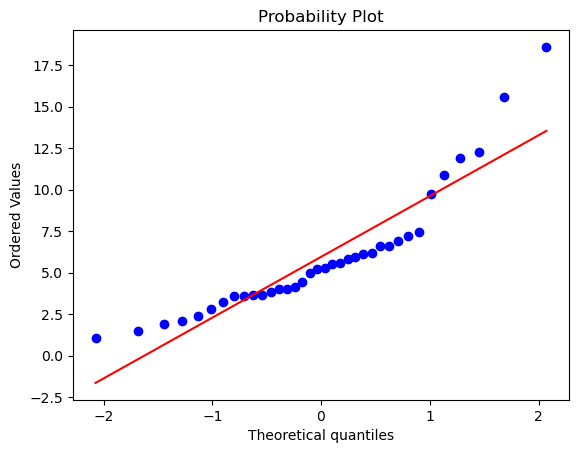

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus          0.00011
Shapiro-Wilk    0.000228
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_C1


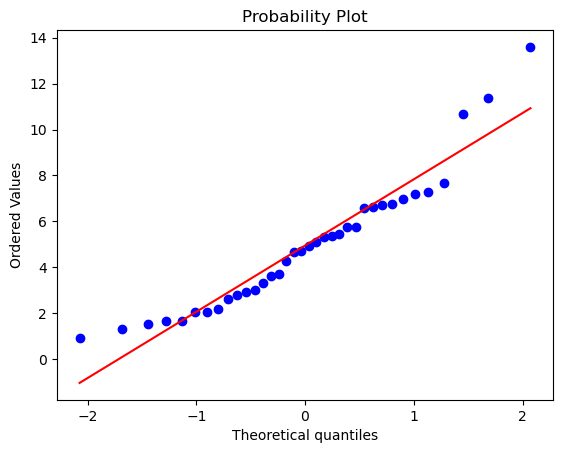

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.014415
Shapiro-Wilk    0.014306
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_CZ


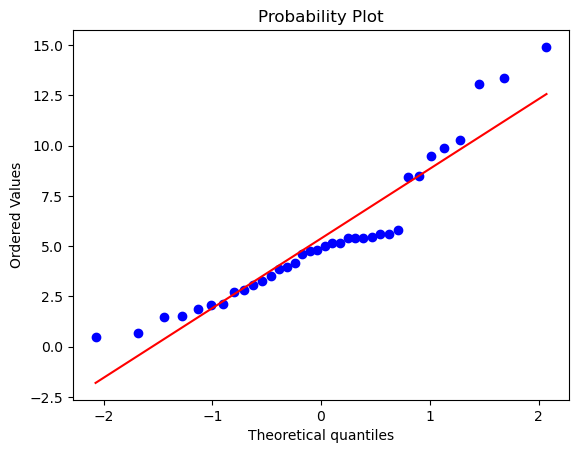

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.013931
Shapiro-Wilk    0.002632
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_C2


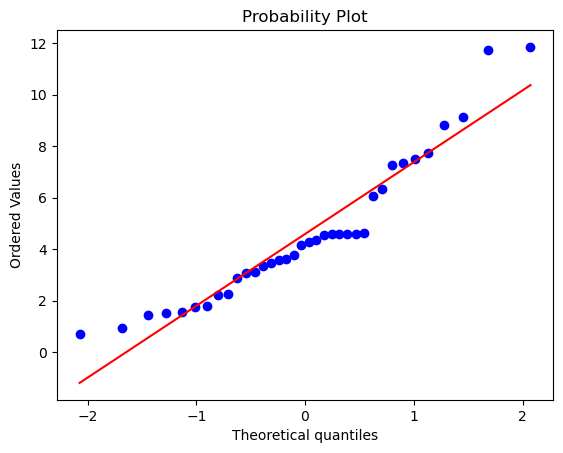

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.031837
Shapiro-Wilk    0.008256
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_C4


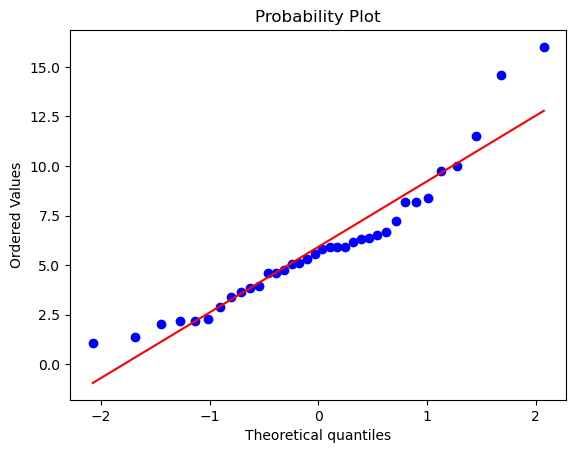

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.002668
Shapiro-Wilk     0.00671
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_O1


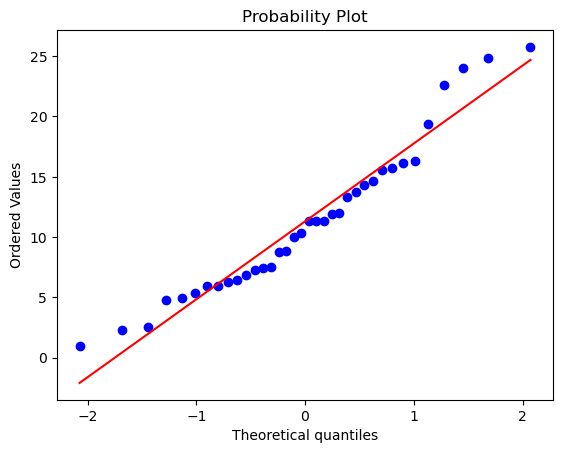

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.214793
Shapiro-Wilk    0.078094
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_OZ


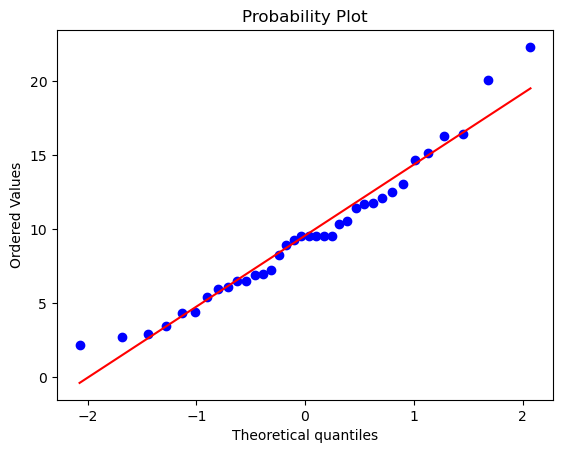

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.139727
Shapiro-Wilk    0.202481
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_O2


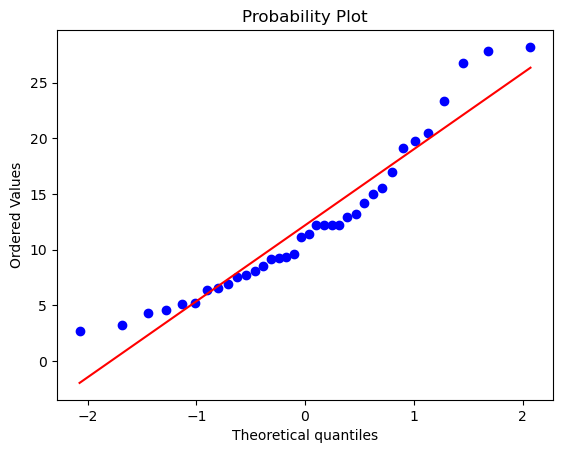

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.067281
Shapiro-Wilk    0.010982
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


In [30]:
names=df.columns.values
normal={"Estado":"Control"}
pcontrol=sum(df["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    print("For chanel: "+i)
    c=df.loc[0:pcontrol-1,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=[True]
    else:
        normal[i]=[False]
norm=pd.DataFrame.from_dict(normal)

For chanel: PSD_C3


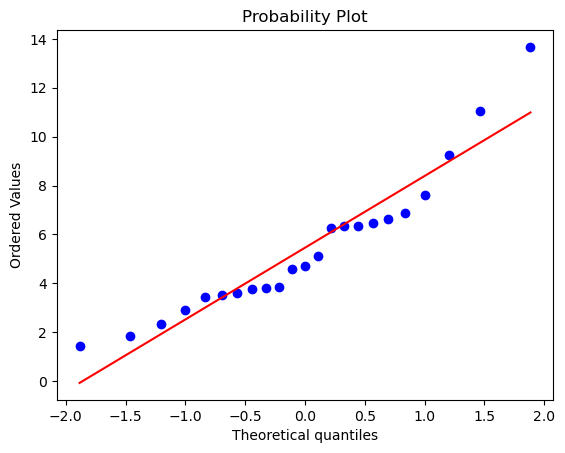

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.018338
Shapiro-Wilk    0.041937
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_C1


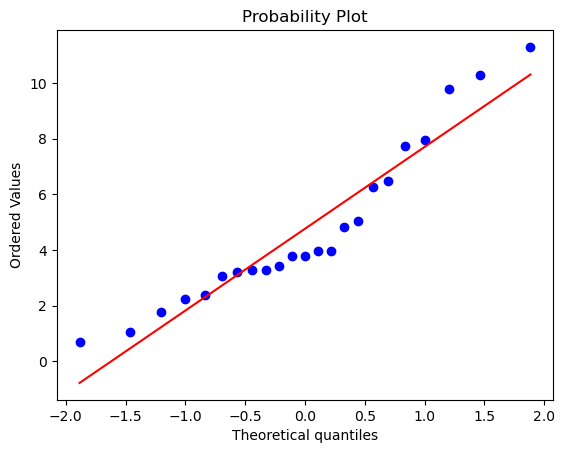

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.185987
Shapiro-Wilk    0.043972
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_CZ


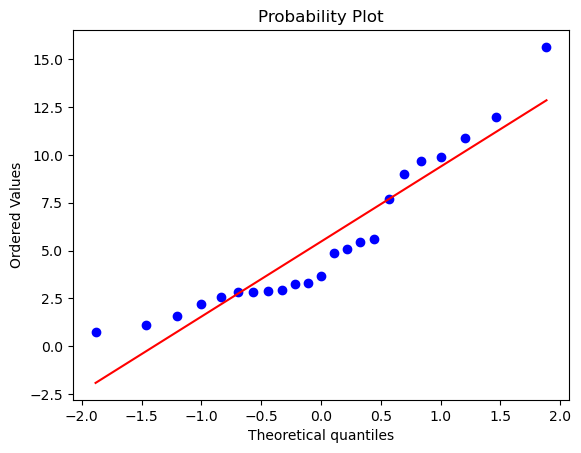

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.089332
Shapiro-Wilk    0.013357
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_C2


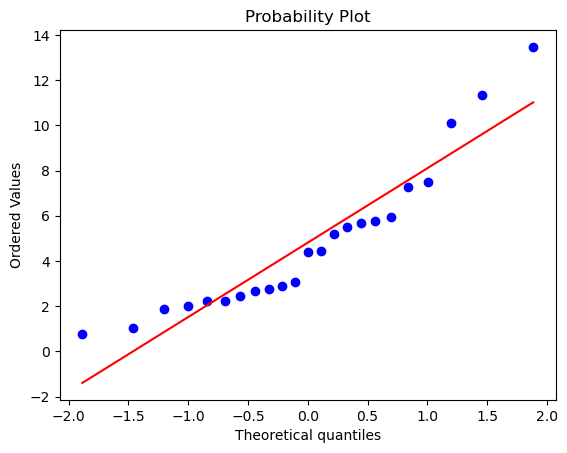

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.035403
Shapiro-Wilk    0.014597
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------
For chanel: PSD_C4


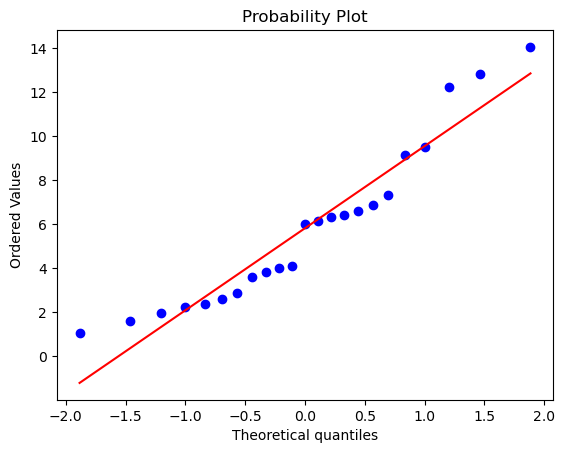

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.220734
Shapiro-Wilk    0.049105
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_O1


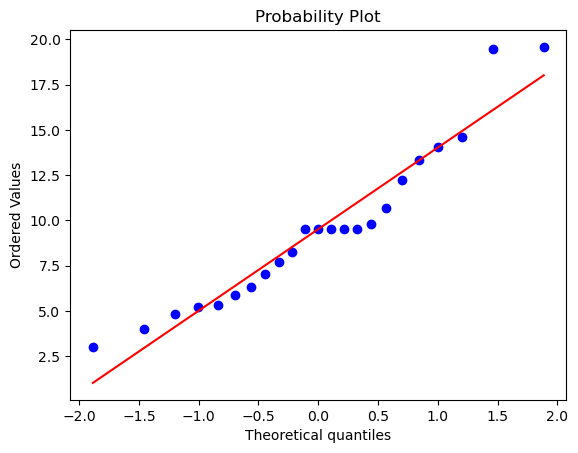

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.168833
Shapiro-Wilk    0.102883
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_OZ


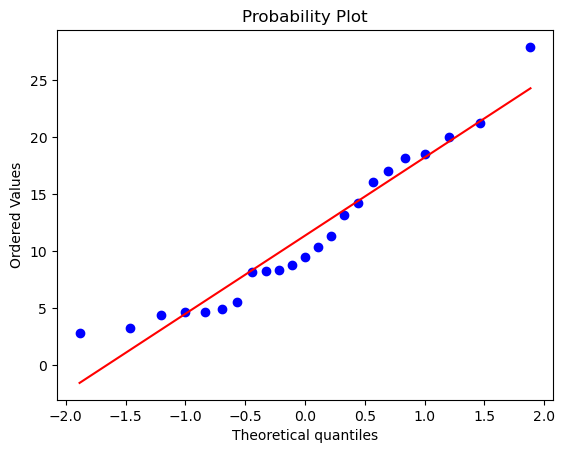

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.313032
Shapiro-Wilk    0.114777
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_O2


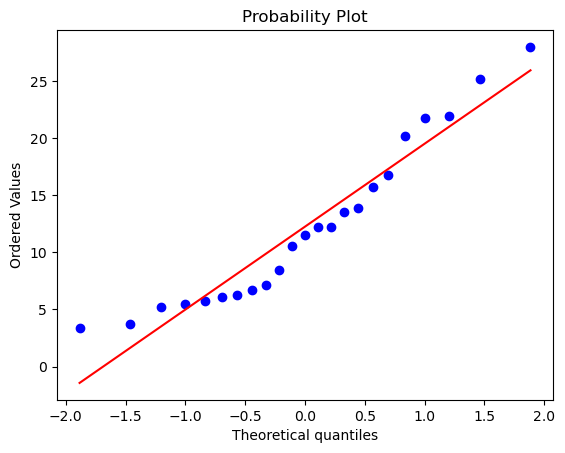

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.285821
Shapiro-Wilk    0.056782
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
Normal distributed data {'Estado': 'Parkinson', 'PSD_C3': False, 'PSD_C1': True, 'PSD_CZ': True, 'PSD_C2': False, 'PSD_C4': True, 'PSD_O1': True, 'PSD_OZ': True, 'PSD_O2': True} for parkinson


C:\Users\MIGUEL\AppData\Local\Temp\ipykernel_14132\4227665256.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  norm=norm.append(normal,ignore_index=True)


In [39]:
names=df.columns.values
normal={"Estado":"Parkinson"}
pcontrol=sum(df["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes parkinson
    print("For chanel: "+i)
    c=df.loc[pcontrol:,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=True
    else:
        normal[i]=False
norm=norm.append(normal,ignore_index=True)
print("Normal distributed data",normal,"for parkinson")

In [45]:
norm

,index,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
0,0,Control,False,False,False,False,False,True,True,True
1,2,Parkinson,False,True,True,False,True,True,True,True


Verificar Homocedasticidad

In [50]:
#VERIFICANDO HOMOSEDASTICIDAD
con=0
namest=[names[6],names[7],names[8]]
homo={}
for i in namest:
  c=df.loc[0:pcontrol-1,i]
  p=df.loc[pcontrol:len(df),i]
  p_valor = levene(c, p).pvalue
  print("Canal %s p=%.3f "% (namest[con],p_valor))
  if p_valor > 0.05:
    print("Los datos son homocedásticos.")
    homo[namest[con]]=[True,p_valor]
  else:
    print("Los datos no son homocedásticos.")
    homo[namest[con]]=[False,p_valor]
  con+=1
print("Homocedásticos")
homocedas=pd.DataFrame.from_dict(homo)
homocedas

Canal PSD_O1 p=0.067 
Los datos son homocedásticos.
Canal PSD_OZ p=0.064 
Los datos son homocedásticos.
Canal PSD_O2 p=0.639 
Los datos son homocedásticos.
Homocedásticos


,PSD_O1,PSD_OZ,PSD_O2
0,True,True,True
1,0.066533,0.064165,0.638971


Prueba T


Se realiza la prueba t sobre los canales O1, Oz y O2 debido a que son los únicos homocedásticos y con distribución normal en ambas poblaciones
Parkinson y pacientes control

In [98]:
con=0
namest=[names[6],names[7],names[8]]
for i in namest:
  c=df.loc[0:pcontrol-1,i]
  p=df.loc[pcontrol:len(df),i]
  print("Canal:%s"%namest[con])
  con+=1
  t=pg.ttest(x=c, y=p, alternative='two-sided', correction=False)
  p=t.loc["T-test","p-val"]
  alpha=0.05
  if p > alpha:
        print('Same distribution (fail to reject H0)')
  else:
        print('Different distribution (reject H0)')
  display(t)

Canal:PSD_O1
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.163852,57,two-sided,0.249333,"[-1.28, 4.84]",0.310677,0.473,0.208301


Canal:PSD_OZ
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.185377,57,two-sided,0.240787,"[-4.77, 1.22]",0.316423,0.483,0.21434


Canal:PSD_O2
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.045009,57,two-sided,0.964258,"[-3.82, 3.65]",0.012015,0.27,0.050224


Para el resto de canales se usa la prueba U

In [49]:
stat, p = mannwhitneyu(control[names[1:6]],parkinson[names[1:6]])
con=0
for i in p: #solo imprimo los resultados de cada canal despues de pasar por la prueba no parametrica
    print('Statistics=%.3f, p=%.3f for channel %s' % (stat[con], i,names[con+1]))
    con+=1
    #interpret
    alpha = 0.05
    if i > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

Statistics=431.000, p=0.798 for channel PSD_C3
Same distribution (fail to reject H0)
Statistics=431.000, p=0.798 for channel PSD_C1
Same distribution (fail to reject H0)
Statistics=426.000, p=0.858 for channel PSD_CZ
Same distribution (fail to reject H0)
Statistics=415.000, p=0.994 for channel PSD_C2
Same distribution (fail to reject H0)
Statistics=422.000, p=0.907 for channel PSD_C4
Same distribution (fail to reject H0)


# Normalizacion

Debido al uso de pruebas no paramétricas para algunos canales se decide intentar normalizar los datos buscando una prueba t de mayor seguridad

In [72]:
df2=df.copy() #Notese que este df no es el usado con datos filtrados si no el original importado por Tabla.cvs
data=np.log(df2.iloc[:,1:9])
data=data.join(pd.DataFrame(df2.iloc[:,0].values,columns=["Estado"]))
a=list(data.columns)
a[0],a[8]=a[8],a[0]
data=data[a]

In [73]:
df=data

In [74]:
df.to_csv("Datos_Normalizados.cvs",index=False)

In [51]:
df=pd.read_csv("Datos_Normalizados.cvs")

# Filtrado 
Se hace un filtro rápido de datos atípicos

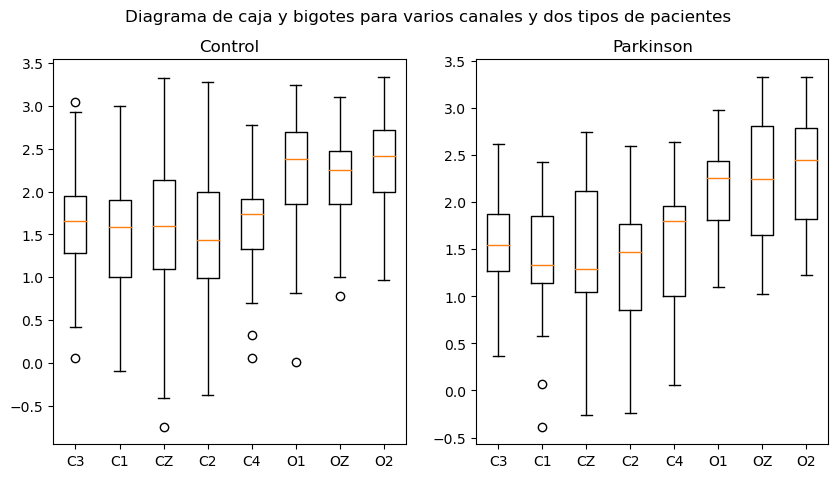

In [52]:
# Crear una lista de dataframes, uno por cada estado
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']
labels1=['C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2']
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

In [55]:
control, parkinson = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

#filtrado para control
print("Filtro control:")
control=filtro(control,5,0.5,False)


#filtrado para parkinson
print("Filtro parkinson:")
parkinson=filtro(parkinson,1,0.5,False)

Filtro control:
Canal PSD_O1 filtrado
Filtro parkinson:
Canal PSD_C1 filtrado


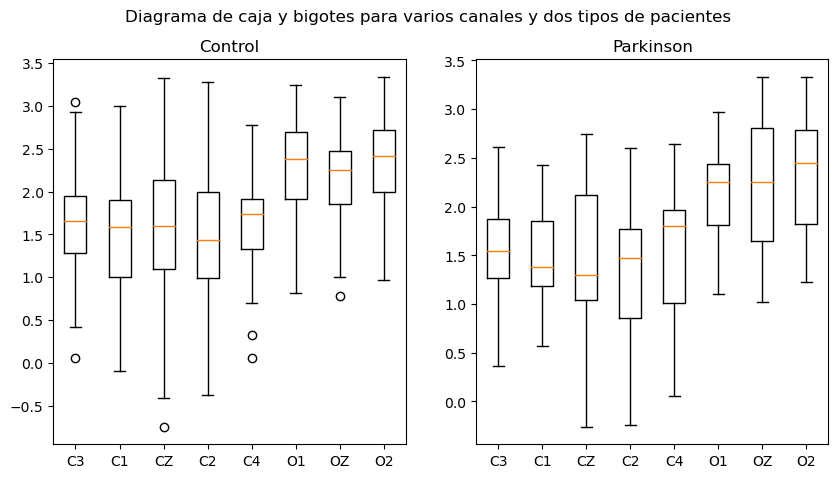

In [56]:
dataframes = control,parkinson
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
    
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

Se vueve a checkear normalidad


In [57]:
df=pd.concat(dataframes,ignore_index=True)

For chanel: PSD_C1


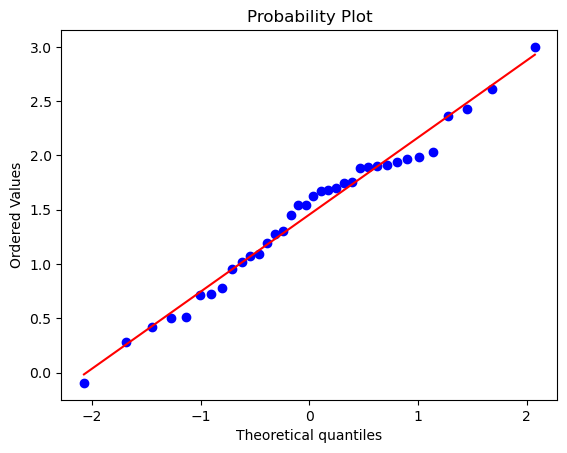

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.917347
Shapiro-Wilk     0.82668
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_CZ


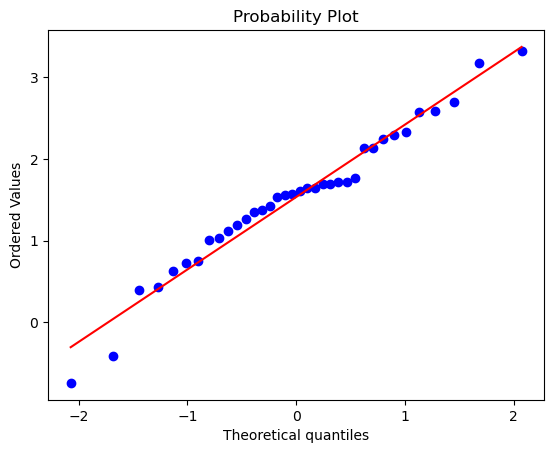

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.329294
Shapiro-Wilk    0.506971
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_C2


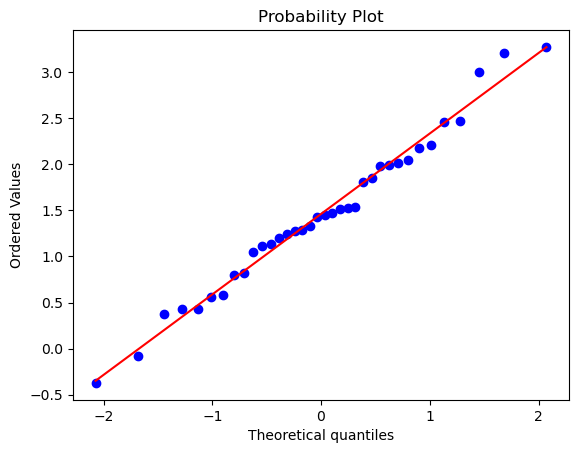

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.890752
Shapiro-Wilk    0.841304
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_C4


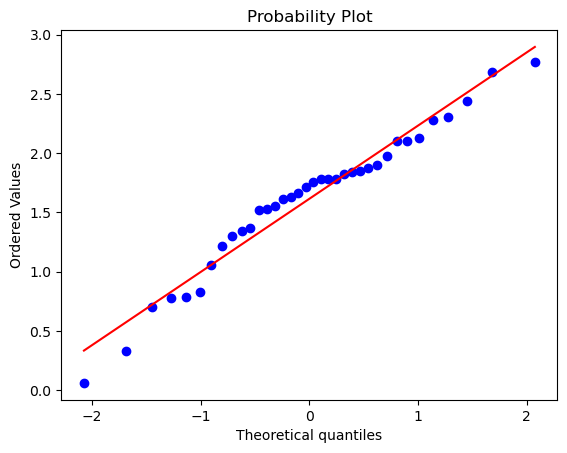

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.267803
Shapiro-Wilk    0.308564
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_O1


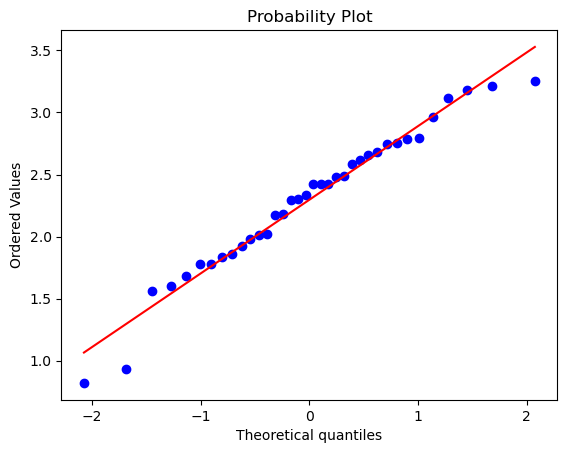

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.320456
Shapiro-Wilk     0.32456
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_OZ


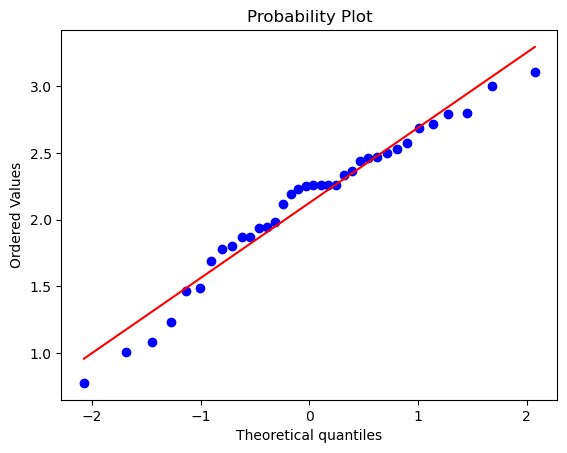

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.256851
Shapiro-Wilk    0.251271
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_O2


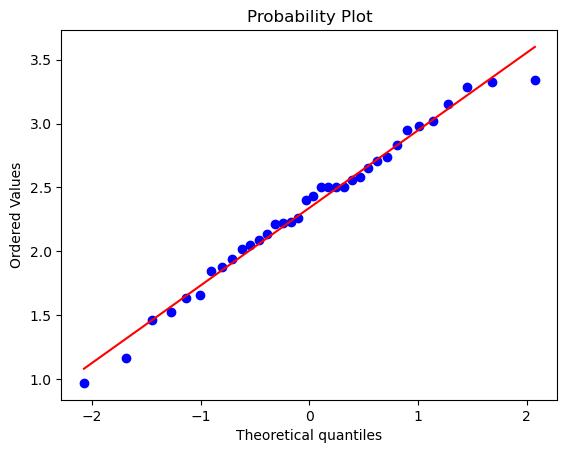

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.727075
Shapiro-Wilk    0.765823
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
For chanel: PSD_C3


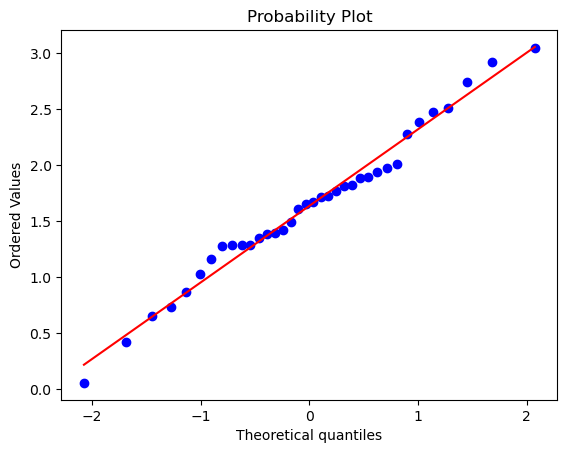

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.871345
Shapiro-Wilk    0.875673
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


In [58]:
names=df.columns.values
normal={"Estado":"Control"}
pcontrol=sum(df["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    print("For chanel: "+i)
    c=df.loc[0:pcontrol-1,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=[True]
    else:
        normal[i]=[False]
norm=pd.DataFrame.from_dict(normal)

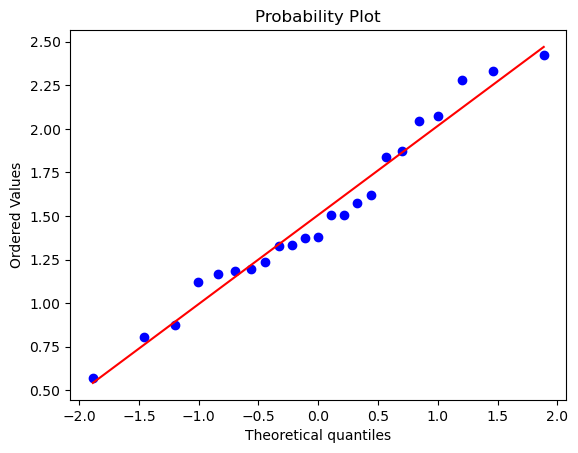

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.775305
Shapiro-Wilk    0.594026
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


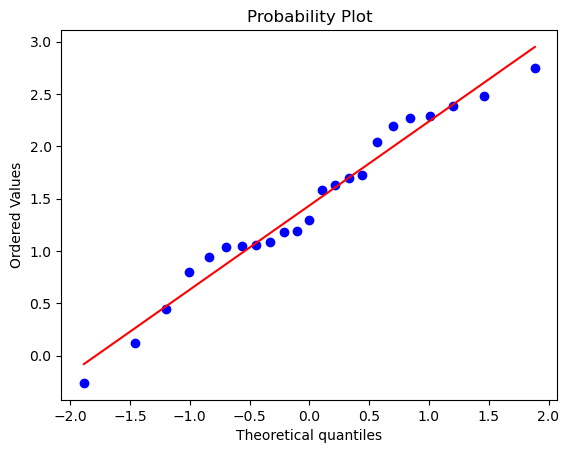

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.827219
Shapiro-Wilk     0.67203
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


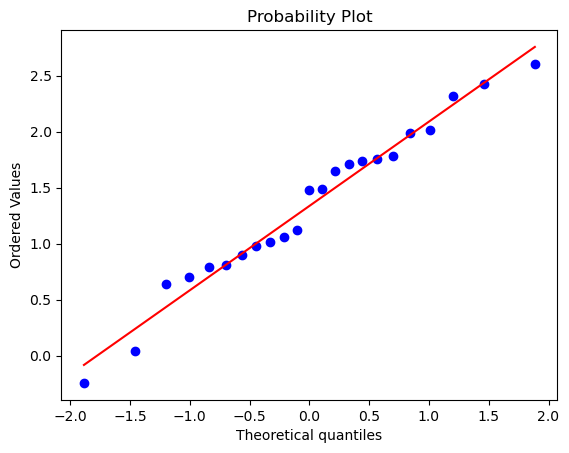

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.839955
Shapiro-Wilk    0.773939
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


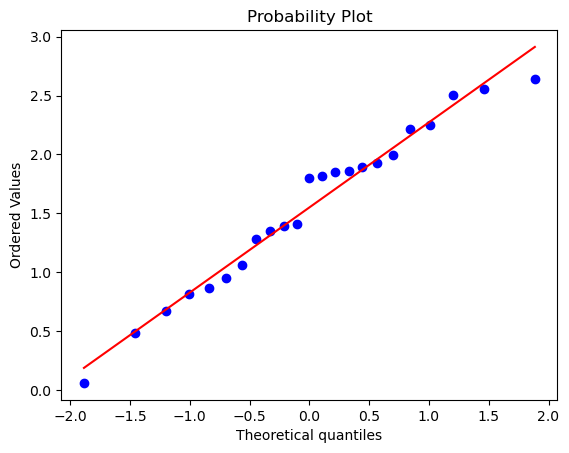

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.652662
Shapiro-Wilk    0.636744
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


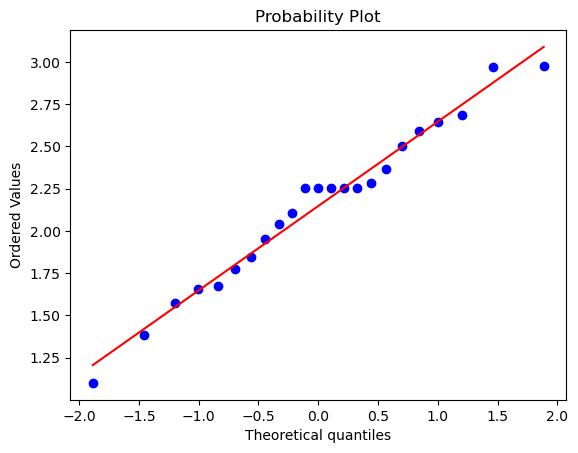

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.864205
Shapiro-Wilk    0.828165
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


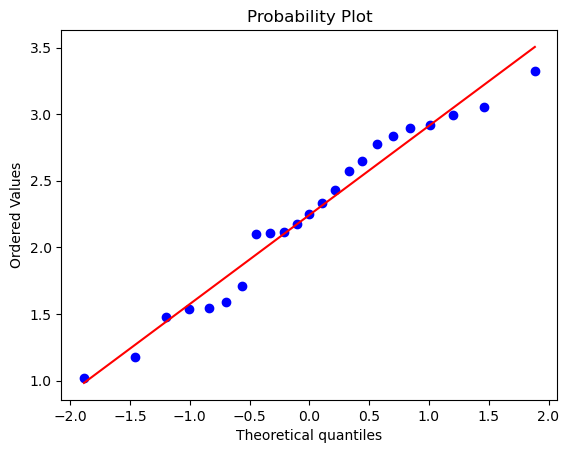

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus          0.39626
Shapiro-Wilk    0.484005
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


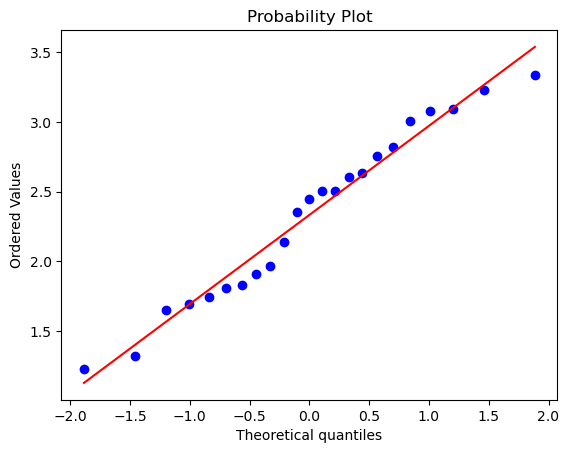

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.302419
Shapiro-Wilk    0.458553
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


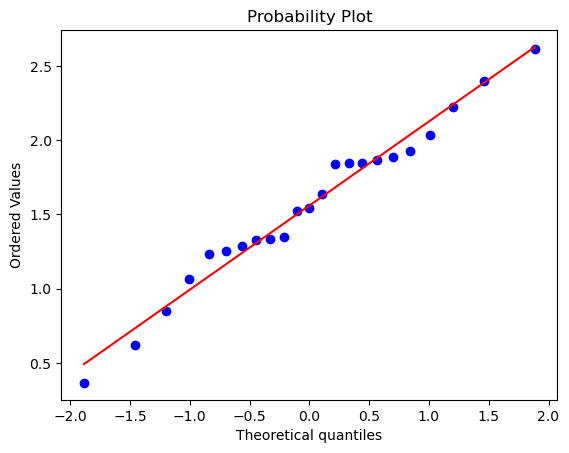

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.835285
Shapiro-Wilk    0.916584
dtype: object
--------------------------------
Data are normally distributed
--------------------------------
Normal distributed data {'Estado': 'Parkinson', 'PSD_C1': True, 'PSD_CZ': True, 'PSD_C2': True, 'PSD_C4': True, 'PSD_O1': True, 'PSD_OZ': True, 'PSD_O2': True, 'PSD_C3': True} for Parkinson


C:\Users\MIGUEL\AppData\Local\Temp\ipykernel_14132\1361659175.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  norm=norm.append(normal,ignore_index=True)


In [59]:
normal={"Estado":"Parkinson"}
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes Parkinson
    c=df.loc[pcontrol:len(df),i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=True
    else:
        normal[i]=False
norm=norm.append(normal,ignore_index=True)
print("Normal distributed data",normal,"for Parkinson")

In [61]:
print("Prueba de normalidad")
norm

Prueba de normalidad


,Estado,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2,PSD_C3
0,Control,True,True,True,True,True,True,True,True
1,Parkinson,True,True,True,True,True,True,True,True


In [ ]:
#VERIFICANDO HOMOSEDASTICIDAD
con=0
namest=[names[6],names[7],names[8]]
homo={}
for i in namest:
  c=df.loc[0:pcontrol-1,i]
  p=df.loc[pcontrol:len(df),i]
  p_valor = levene(c, p).pvalue
  print("Canal %s p=%.3f "% (namest[con],p_valor))
  if p_valor > 0.05:
    print("Los datos son homocedásticos.")
    homo[namest[con]]=[True,p_valor]
  else:
    print("Los datos no son homocedásticos.")
    homo[namest[con]]=[False,p_valor]
  con+=1
print("Homocedásticos")
homocedas=pd.DataFrame.from_dict(homo)
homocedas

In [64]:
#VERIFICANDO HOMOSEDASTICIDAD
con=0
homo={}
for i in names[1:]:
  c=df.loc[0:pcontrol-1,i]
  p=df.loc[pcontrol:len(df),i]
  p_valor = levene(c, p).pvalue
  print("Canal %s p=%.3f "% (names[con+1],p_valor))
  if p_valor > 0.05:
    print("Los datos son homocedásticos.")
    homo[names[con+1]]=[True,p_valor]
  else:
    print("Los datos no son homocedásticos.")
    homo[names[con+1]]=[False,p_valor]
  con+=1
print("Homocedásticos")
homocedas=pd.DataFrame.from_dict(homo)
homocedas

Canal PSD_C1 p=0.124 
Los datos son homocedásticos.
Canal PSD_CZ p=0.962 
Los datos son homocedásticos.
Canal PSD_C2 p=0.681 
Los datos son homocedásticos.
Canal PSD_C4 p=0.293 
Los datos son homocedásticos.
Canal PSD_O1 p=0.325 
Los datos son homocedásticos.
Canal PSD_OZ p=0.256 
Los datos son homocedásticos.
Canal PSD_O2 p=0.598 
Los datos son homocedásticos.
Canal PSD_C3 p=0.477 
Los datos son homocedásticos.
Homocedásticos


,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2,PSD_C3
0,True,True,True,True,True,True,True,True
1,0.123527,0.962051,0.68121,0.292616,0.324881,0.255633,0.597827,0.477431


Se aplica la prueba T ya que los datos son Homocedasticos y tienen una distribución normal


In [82]:
con=0
dfp=df[df["Estado"]=="Parkinson"]
dfc=df[df["Estado"]=="Control"]
for i in names[1:]:
  c=dfc.loc[:,i]
  p=dfp.loc[:,i] 
  print("Canal:%s"%names[con+1])
  con+=1
  t=pg.ttest(x=c, y=p, alternative='two-sided', correction=False)
  p=t.loc["T-test","p-val"]
  alpha=0.05
  if p > alpha:
        print('Same distribution (fail to reject H0)')
  else:
        print('Different distribution (reject H0)')
  display(t)

Canal:PSD_C1
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.302917,57,two-sided,0.763056,"[-0.38, 0.28]",0.08086,0.28,0.060223


Canal:PSD_CZ
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.443668,57,two-sided,0.658962,"[-0.35, 0.55]",0.118432,0.293,0.072072


Canal:PSD_C2
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.579379,57,two-sided,0.564617,"[-0.31, 0.55]",0.154658,0.31,0.087929


Canal:PSD_C4
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.381252,57,two-sided,0.704433,"[-0.28, 0.41]",0.101771,0.287,0.066248


Canal:PSD_O1
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.02406,57,two-sided,0.310134,"[-0.14, 0.44]",0.273361,0.417,0.171776


Canal:PSD_OZ
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.746197,57,two-sided,0.458615,"[-0.43, 0.2]",0.199189,0.34,0.113581


Canal:PSD_O2
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.046144,57,two-sided,0.963357,"[-0.31, 0.33]",0.012318,0.27,0.050236


Canal:PSD_C3
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.457343,57,two-sided,0.649163,"[-0.26, 0.41]",0.122082,0.294,0.07347
